In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import requests as rq
from glob import glob
from tqdm.auto import tqdm

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import Phylo, AlignIO, SeqIO
from Bio.Align.Applications import ClustalwCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

In [2]:
uniprot = pd.read_csv('seqs/csv/uniprot-filtered-reviewed_yes.tab', sep='\t', index_col=0).drop_duplicates('Sequence')
uniprot = uniprot[~uniprot['Domain [FT]'].isna()].copy()
uniprot = uniprot[uniprot['Domain [FT]'].str.lower().str.contains('upar')].copy()
uniprot

,Entry name,Protein names,Gene names,Organism,Length,Domain [FT],Sequence
Entry,,,,,,,
P0DP61,SLUR2_MACMU,Secreted Ly-6/uPAR domain-containing protein 2,SLURP2,Macaca mulatta (Rhesus macaque),97,"DOMAIN 23..95; /note=""UPAR/Ly6""",MQFHTGLLLAAVLSLQLAAAQALWCHQCTGFGGCSRGSRCPRDSTH...
P55000,SLUR1_HUMAN,Secreted Ly-6/uPAR-related protein 1 (SLURP-1)...,SLURP1 ARS,Homo sapiens (Human),103,"DOMAIN 24..73; /note=""UPAR/Ly6""",MASRWAVQLLLVAAWSMGCGEALKCYTCKEPMTSASCRTITRCKPE...
P83107,SOLD1_BOVIN,Secreted protein of Ly-6 domain 1 (Protein BOP1),SOLD1 BOP1,Bos taurus (Bovine),100,"DOMAIN 23..100; /note=""UPAR/Ly6""; /evidence=...",MAKCLLLLLLVVLSSLLGLPQALECFQCNRVNASGVCETGGSTCQT...
P0DP57,SLUR2_HUMAN,Secreted Ly-6/uPAR domain-containing protein 2...,SLURP2,Homo sapiens (Human),97,"DOMAIN 25..95; /note=""UPAR/Ly6""; /evidence=""...",MQLGTGLLLAAVLSLQLAAAEAIWCHQCTGFGGCSHGSRCLRDSTH...
D3YWX3,PAT13_MOUSE,Prostate and testis expressed protein 13 (Pros...,Pate13 Gm3867 Pate-X,Mus musculus (Mouse),137,"DOMAIN 28..114; /note=""UPAR/Ly6""; /evidence=...",MFQKLLLSVFIILLMDVGERVLTFNLLRHCNLCSHYDGFKCRNGMK...
...,...,...,...,...,...,...,...
Q9GK80,UPAR_PANTR,Urokinase plasminogen activator surface recept...,PLAUR UPAR,Pan troglodytes (Chimpanzee),335,"DOMAIN 23..114; /note=""UPAR/Ly6 1""; DOMAIN 11...",MGHPPLLPLLLLLHTCVPASWGLRCMQCKTNGDCRVEECALGQDLC...
P35456,UPAR_MOUSE,Urokinase plasminogen activator surface recept...,Plaur,Mus musculus (Mouse),327,"DOMAIN 24..117; /note=""UPAR/Ly6 1""; DOMAIN 11...",MGLPRRLLLLLLLATTCVPASQGLQCMQCESNQSCLVEECALGQDL...
P57096,PSCA_MOUSE,Prostate stem cell antigen,Psca,Mus musculus (Mouse),123,"DOMAIN 21..95; /note=""UPAR/Ly6""",MKTVFFLLLATYLALHPGAALQCYSCTAQMNNRDCLNVQNCSLDQH...


In [3]:
known_upars = set(pd.read_csv('seqs/csv/acess_upar.txt', squeeze=True)) | set(uniprot.index)
len(known_upars)

198

In [4]:
def retrieve(acess):
    """
    Retrieve protein by ID from UniProt
    """
    requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins/{acess}"
#     print(requestURL)
    r = rq.get(requestURL, headers={ "Accept" : "application/json"})

    if not r.ok:
        r.raise_for_status()
        return 0
    responseBody = r.json()

    try:
        features = responseBody['features']
    except KeyError:
        type_ = None
        start, end = np.nan, np.nan
    else:
        st_nd = [(start := i['begin'], end := i['end']) for i in features if i.get('description') and i['description'] == 'UPAR/Ly6']
        type_ = 'DOMAIN'
        if not st_nd:
            type_ = 'CHAIN'
            st_nd = [(start := i['begin'], end := i['end']) for i in features if i['type'] == 'CHAIN'] 

    try:
        prot_name = responseBody['protein']['submittedName'][0]['fullName']['value']

    except:
        prot_name = responseBody['protein']['recommendedName']['fullName']['value']
    
    return {'sequence': responseBody['sequence']['sequence'],
            'id': responseBody['id'],
            'protein_name': prot_name,
            'org': responseBody['organism']['names'][0]['value'],
            'start': start,
            'end': end,
            'type_': type_,
            'acess': acess}

In [5]:
res = pd.DataFrame()
for acess in tqdm(known_upars):
    tmp = retrieve(acess)
    if tmp:
        res = res.append(tmp, ignore_index=True)
    else:
        print('!!!!!!!!!!!!!!!')
        break
res = res.drop_duplicates('sequence')

short = res[res.sequence.str.len() < 190].copy()
short = short.fillna(-1)
short.start, short.end = short.start.astype(np.int32), short.end.astype(np.int32)

long = res[res.sequence.str.len() > 190].copy()

  0%|          | 0/198 [00:00<?, ?it/s]

In [6]:
res.shape[0] == res.drop_duplicates('id').shape[0]

True

In [7]:
print(long.shape, short.shape)
res

(44, 8) (153, 8)


,acess,end,id,org,protein_name,sequence,start,type_
0,Q9WUC3,113,LY6H_MOUSE,Mus musculus,Lymphocyte antigen 6H,MLPAAMKSLGLALLALLLCPSPAHGLWCQDCTLANSSHCAPKQCQP...,26,DOMAIN
1,Q8BVP6,223,LYPD4_MOUSE,Mus musculus,Ly6/PLAUR domain-containing protein 4,MILQAWRSLQLLYLLEAISLLPCTEALLCYEATASAFRAVSLHNWK...,142,DOMAIN
2,P60305,60,3SA8_NAJKA,Naja kaouthia,Cytotoxin 1,LKCNKLIPIASKTCPAGKNLCYKMFMMSDLTIPVKRGCIDVCPKNS...,1,CHAIN
3,P83121,99,UP3_RAT,Rattus norvegicus,Urinary protein 3,MGKHILLLPLGLSLLMSSLLALQCFRCISFDSTGFCYVGRHICQTY...,22,DOMAIN
4,Q8R2S8,817,CD177_MOUSE,Mus musculus,CD177 antigen,MNSIPVLTLLGVTALLPCVPALTCQKSSAQAVRNVAELPLRWWGAG...,22,CHAIN
...,...,...,...,...,...,...,...,...
193,P82935,86,3NO2_NAJKA,Naja kaouthia,Tryptophan-containing weak neurotoxin,MKTLLLTLVVVTIVCLDLGYTLTCLNCPEMFCGKFQICRNGEKICF...,22,CHAIN
194,P36896,505,ACV1B_HUMAN,Homo sapiens,Activin receptor type-1B,MAESAGASSFFPLVVLLLAGSGGSGPRGVQALLCACTSCLQANYTC...,24,CHAIN
195,P0CW02,115,LY6C1_MOUSE,Mus musculus,Lymphocyte antigen 6C1,MDTSHTTKSCVLILLVALLCAERAQGLQCYECYGVPIETSCPAVTC...,27,DOMAIN
196,P47777,111,CD59_SAISC,Saimiri sciureus,CD59 glycoprotein,MGIQGGSVLFGLLLVLAVFCHSGNSLQCYSCPLPTMESMECTASTN...,26,DOMAIN


In [8]:
def get_domain(x):
    n_st, n_end = 0, len(x)
    result = []
    for st, en in itertools.product(np.arange(n_st, n_end - 20), np.arange(n_st + 20, n_end + 1)):
        if len((string := x[st: en])) > 45:
            if 'CN' == string[-2:] and string[2] == 'C' and string.count('C') % 2 == 0 and string.count('C') >= 8 and string.count('C') <= 10 and len(string) < 100:
                result.append(string)
            
    return max(result, key=lambda x: len(x)) if result else np.nan

In [9]:
short['domain'] = short.sequence.apply(get_domain)

inds = short[short.domain.isna()].index
print(inds)
for i in inds:
    short.loc[i, 'domain'] = short.loc[i, 'sequence'][short.loc[i, 'start']: short.loc[i, 'end']]
short

Int64Index([36], dtype='int64')


,acess,end,id,org,protein_name,sequence,start,type_,domain
0,Q9WUC3,113,LY6H_MOUSE,Mus musculus,Lymphocyte antigen 6H,MLPAAMKSLGLALLALLLCPSPAHGLWCQDCTLANSSHCAPKQCQP...,26,DOMAIN,LWCQDCTLANSSHCAPKQCQPTDTVCASVRITDPSSSRKDHSVNKM...
2,P60305,60,3SA8_NAJKA,Naja kaouthia,Cytotoxin 1,LKCNKLIPIASKTCPAGKNLCYKMFMMSDLTIPVKRGCIDVCPKNS...,1,CHAIN,LKCNKLIPIASKTCPAGKNLCYKMFMMSDLTIPVKRGCIDVCPKNS...
3,P83121,99,UP3_RAT,Rattus norvegicus,Urinary protein 3,MGKHILLLPLGLSLLMSSLLALQCFRCISFDSTGFCYVGRHICQTY...,22,DOMAIN,LQCFRCISFDSTGFCYVGRHICQTYPDEICAWVVVTTRDGKFVYGN...
5,P25683,60,3SL8_DENJA,Dendroaspis jamesoni kaimosae,Toxin S4C8,RICYTHKSLQAKTTKSCEGNTCYKMFIRTSREYISERGCGCPTAMW...,1,CHAIN,RICYTHKSLQAKTTKSCEGNTCYKMFIRTSREYISERGCGCPTAMW...
7,Q28785,106,CD59_PAPSP,Papio sp.,CD59 glycoprotein,MGIQGGSVLFGLLLALAVFCHSGHSLQCYNCPNPTTNCKTAINCSS...,26,DOMAIN,LQCYNCPNPTTNCKTAINCSSGFDTCLIARAGLQVYNQCWKFANCN...
...,...,...,...,...,...,...,...,...,...
191,Q1RMQ4,105,LYNX1_BOVIN,Bos taurus,Ly-6/neurotoxin-like protein 1,MTPLLALFLVALVGLPVAQALDCHVCAYNGENCFNPMRCPAMVSYC...,21,DOMAIN,LDCHVCAYNGENCFNPMRCPAMVSYCMTTRTYYTPTRMKVSKSCVP...
192,Q8SQ46,108,CD59_MACFA,Macaca fascicularis,CD59 glycoprotein,MGIQGGSVLFGLLLVLAVFCHSGHSLQCYNCPNPTTDCKTAINCSS...,26,DOMAIN,LQCYNCPNPTTDCKTAINCSSGFDTCLIARAGLQVYNQCWKFANCN...
193,P82935,86,3NO2_NAJKA,Naja kaouthia,Tryptophan-containing weak neurotoxin,MKTLLLTLVVVTIVCLDLGYTLTCLNCPEMFCGKFQICRNGEKICF...,22,CHAIN,LTCLNCPEMFCGKFQICRNGEKICFKKLHQRRPLSWRYIRGCADTC...
195,P0CW02,115,LY6C1_MOUSE,Mus musculus,Lymphocyte antigen 6C1,MDTSHTTKSCVLILLVALLCAERAQGLQCYECYGVPIETSCPAVTC...,27,DOMAIN,LQCYECYGVPIETSCPAVTCRASDGFCIAQNIELIEDSQRRKLKTR...


In [10]:
def save_df_to_fasta(df, filename, seq_col='sequence', org='org', protein_name='protein_name'):
    req_list = []
    for ind, row in df.iterrows():
        req_list.append(SeqRecord(seq=Seq(row[seq_col]),
                                  id=row.id,
                                  name=row[protein_name],
                                  description='| ' + row[protein_name] + ' | ' + row[org]
                                 ))
    with open(filename, 'w') as f:
        SeqIO.write(req_list, f, 'fasta')

In [11]:
save_df_to_fasta(short, 'blast/blastdb/short_ly_domain_db.fs', seq_col='sequence')

In [12]:
%%bash -s 'short_ly_domain_db.fs'
cd 'blast/blastdb/'
makeblastdb -in "$1" -dbtype prot



Building a new DB, current time: 11/02/2021 14:11:02
New DB name:   /home/user503/python/Filogenetics/blast/blastdb/short_ly_domain_db.fs
New DB title:  short_ly_domain_db.fs
Sequence type: Protein
Deleted existing Protein BLAST database named /home/user503/python/Filogenetics/blast/blastdb/short_ly_domain_db.fs
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 153 sequences in 0.00339198 seconds.


In [13]:
%%bash -s 'blastdb/short_ly_domain_db.fs' 'aplanci_blast_short.txt' 'arubens_blast_short.txt'
cd 'blast'
blastp -db "$1" -query "../seqs/aplanci_seq.fasta" -outfmt 6 -evalue 1e-5 -num_threads 4 -out "$2"
blastp -db "$1" -query "../seqs/arubens_seq.fasta" -outfmt 6 -evalue 1e-5 -num_threads 4 -out "$3"
ls

aplanci_blast_short.txt
arubens_blast_short.txt
blastdb


In [14]:
def read_blast(name):
    df = pd.read_csv(f'seqs/csv/{name}', index_col=0)
    bl_name = name.split('_', 1)[0]
    bl = pd.read_csv(f'blast/{bl_name}_blast_short.txt', index_col=0, sep='\t', header=None).index.unique().tolist()
    df = df.loc[bl].copy()
    return df[df.sequence.str.len() < 190].drop_duplicates()

In [15]:
aru = read_blast('arubens_seq.csv')
apl = read_blast('aplanci_seq.csv')
print(aru.shape[0], apl.shape[0])

13 13


In [16]:
aru['domain'] = aru.sequence.apply(get_domain)
aru['org'] = 'Asterias rubens'
aru

,sequence,gene_len,domain,org
genes,,,,
XP_033628517.1,MRIKMVFKFRRNSEGIFCILMTLMIILMAVCFRTASSLQCFTCEAE...,155,ENCNIKEAPVLKTCTSRQDRCLTQVIYSTERGKLRIDKECTTEDGC...,Asterias rubens
XP_033627087.1,MKLIIFTLILAFPGQVECLDCYTCTYGIETLRTNTAACGDPFNTNG...,132,YTCTYGIETLRTNTAACGDPFNTNGPHVVKTGCYPTQDPVCAKRRD...,Asterias rubens
XP_033638845.1,MDSSLRLMLLVMVLSACLGGLDGFDCYLCGYDNSLPDNMPSCNDPF...,139,PSCNDPFDVSDPSISETAMQCEGVCSKSSVINGNITAVSRECLEDI...,Asterias rubens
XP_033638895.1,MKAFIAIVFIAAFIDFGNAISCYECAGTGSSACGDPFSGSSSVEKT...,126,SACGDPFSGSSSVEKTDCSSSILYDDMCWKATTSSGLISRSCSAFG...,Asterias rubens
XP_033638855.1,MKGPMYTMLVLGLVGLAASLQCYDCEYNNYAYSGNSCEAPDPTAKK...,122,YDCEYNNYAYSGNSCEAPDPTAKKSTCNGECQKVHIEGSGMVSITR...,Asterias rubens
XP_033639062.1,MKGPMYALLVLGLVGLTSSVRCYECEYTSTNGLSNSCEAPDATTPK...,123,NSCEAPDATTPKASCEGECRKVYTEGGGIVSITRSCEAPFCFDHKC...,Asterias rubens
XP_033638835.1,MNRGSAARVDIPAPPSNLFTSLSSPYSVYQRIFSSNRLIESERIGI...,171,SSCEAPSESAIKRTCDGTCMKTYSEVGSLVTITRSCTSQCIALDCV...,Asterias rubens
XP_033638913.1,MNTLATIVVLMSLIAGMSALTCNTCGWITGVSDESCLDEFDATASN...,126,ESCLDEFDATASNSSVTCASGYDMCSKSTTKVSGTVTILARGCSTS...,Asterias rubens
XP_033640057.1,MLLSWPLGIKQWLSPVLFYVVLMSTCSAPTEPTLIFSYDDSTPFPN...,178,RECNERAYDAFCPKGTKYCYSSHYLNQKSGESILVNKKCALQEECT...,Asterias rubens


In [17]:
apl['domain'] = apl.sequence.apply(get_domain).tolist()
apl['org'] = 'Acanthaster planci'
apl

,sequence,gene_len,domain,org
genes,,,,
XP_022085035.1,MGRGGRMDEWAGTVVIVVGCIFFGLAAAAEFSCYDCAALLSPESSC...,152,SSCETGPDFNSTTKCKTYCYTDVTTQAGVRSYMKRGCTTELECTEE...,Acanthaster planci
XP_022086583.1,MKLFEVVLFLSFVGNIMGRECYVCGPGSSCSDPFTGSDSLKQTCSS...,122,SSCSDPFTGSDSLKQTCSSEKYCFKEKIEFQGTSSVTRSCSDCARD...,Acanthaster planci
XP_022086696.1,MKVFVVAILMTCIGGIMGLQCYTCASTTSEACADPFNAEGSGVLTL...,129,EACADPFNAEGSGVLTLNCTSGQDVCQKSSSMASGLSVVSRSCASQ...,Acanthaster planci
XP_022086630.1,MKMHPINLIFSLVGNVVGLECFDCVDGVSPALDTVACADLFNRTTT...,135,VACADLFNRTTTDSRVNRRPCPAGFDACAKAKASEGSLTLTARKCY...,Acanthaster planci
XP_022086627.1,MKLFEAIVFLSFVGGVMGISCYVCSTGQAGCDDPFKPSDALKRNCT...,127,AGCDDPFKPSDALKRNCTSDYNACYKVKGEVLGITVVERQCEKKSQ...,Acanthaster planci
XP_022086885.1,MAWSLILLALVCTPFAVMGEENMYCFKCAANPECETSVRSDSDNVF...,127,FKCAANPECETSVRSDSDNVFLGKCQGVCYDRRITHIAYKETLVYR...,Acanthaster planci
XP_022094218.1,MRIPAIAFLLLTLAIGHAVSLKCFQCYWLSDQGRGEFGPRACRDPF...,140,RACRDPFNSNSTRVREETCRQNNQCRKEYATTPGSDVIEEVSRGCT...,Acanthaster planci
XP_022094712.1,MWCSMLDLFIASLLICIHTVYSLQCYTCAAEDTNENCKINEAPVLR...,137,ENCKINEAPVLRTCPSTEDRCLTQVIYSTERGKLRIDKYCASQDGC...,Acanthaster planci
XP_022096499.1,MKVLLLSMLTLSVCVAGSYAVRCYACTGAISPALNTWCNDPFDEEN...,132,TWCNDPFDEENAAAQASIQTCNGECVKSYSKIGDLEGYVRECSNVT...,Acanthaster planci


In [18]:
df = pd.concat([short.set_index('id'), apl]).fillna('').reset_index().rename(columns={'index': 'id'})
save_df_to_fasta(df, 'seqs/blast_apl_short_upar.fasta', seq_col='domain')

In [19]:
df = pd.concat([short.set_index('id'), aru]).fillna('').reset_index().rename(columns={'index': 'id'})
save_df_to_fasta(df, 'seqs/blast_aru_short_upar.fasta', seq_col='domain')

In [20]:
def align(in_, out):
    fasta, align = in_, out

    cmd = ClustalwCommandline('clustalw', infile=fasta, align=True,
                              matrix='matrix.txt', pwmatrix='matrix.txt',
                              type='PROTEIN', outfile=align, quiet=False)
    x = cmd()
    for i in x:
        print(i)
    
    os.rename(fasta.rsplit('.', 1)[0] + '.dnd',
              align.rsplit('.', 1)[0] + '.dnd')

In [21]:
align('seqs/blast_aru_short_upar.fasta', 'result/aln/blast_aru_short_align.aln')




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to Protein
Sequence format is Pearson
Sequence 1: LY6H_MOUSE          85 aa
Sequence 2: 3SA8_NAJKA          60 aa
Sequence 3: UP3_RAT             76 aa
Sequence 4: 3SL8_DENJA          59 aa
Sequence 5: CD59_PAPSP          70 aa
Sequence 6: A0A1L8F8M0_XENLA    76 aa
Sequence 7: UP1_RAT             76 aa
Sequence 8: CD59_PONAB          70 aa
Sequence 9: LY6G_MOUSE          79 aa
Sequence 10: LY66C_BOVIN         79 aa
Sequence 11: B8Y6H3_SCHMA        72 aa
Sequence 12: SLUR2_MOUSE         73 aa
Sequence 13: 3SX0_MICAT          57 aa
Sequence 14: LPD6B_HUMAN         70 aa
Sequence 15: LY6E_HUMAN          79 aa
Sequence 16: PATE2_HUMAN         80 aa
Sequence 17: HDBP1_HUMAN         75 aa
Sequence 18: LY65C_HUMAN         78 aa
Sequence 19: SLUR1_HUMAN         78 aa
Sequence 20: 3NO4_BUNCA          66 aa
Sequence 21: C5IWP3_NILLU        93 aa
Sequence 22: 3SLS_DENPO          59 aa
Sequence 23: LY6C2_MOUSE         76 a

In [22]:
align('seqs/blast_apl_short_upar.fasta', 'result/aln/blast_apl_short_align.aln')




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to Protein
Sequence format is Pearson
Sequence 1: LY6H_MOUSE          85 aa
Sequence 2: 3SA8_NAJKA          60 aa
Sequence 3: UP3_RAT             76 aa
Sequence 4: 3SL8_DENJA          59 aa
Sequence 5: CD59_PAPSP          70 aa
Sequence 6: A0A1L8F8M0_XENLA    76 aa
Sequence 7: UP1_RAT             76 aa
Sequence 8: CD59_PONAB          70 aa
Sequence 9: LY6G_MOUSE          79 aa
Sequence 10: LY66C_BOVIN         79 aa
Sequence 11: B8Y6H3_SCHMA        72 aa
Sequence 12: SLUR2_MOUSE         73 aa
Sequence 13: 3SX0_MICAT          57 aa
Sequence 14: LPD6B_HUMAN         70 aa
Sequence 15: LY6E_HUMAN          79 aa
Sequence 16: PATE2_HUMAN         80 aa
Sequence 17: HDBP1_HUMAN         75 aa
Sequence 18: LY65C_HUMAN         78 aa
Sequence 19: SLUR1_HUMAN         78 aa
Sequence 20: 3NO4_BUNCA          66 aa
Sequence 21: C5IWP3_NILLU        93 aa
Sequence 22: 3SLS_DENPO          59 aa
Sequence 23: LY6C2_MOUSE         76 a

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

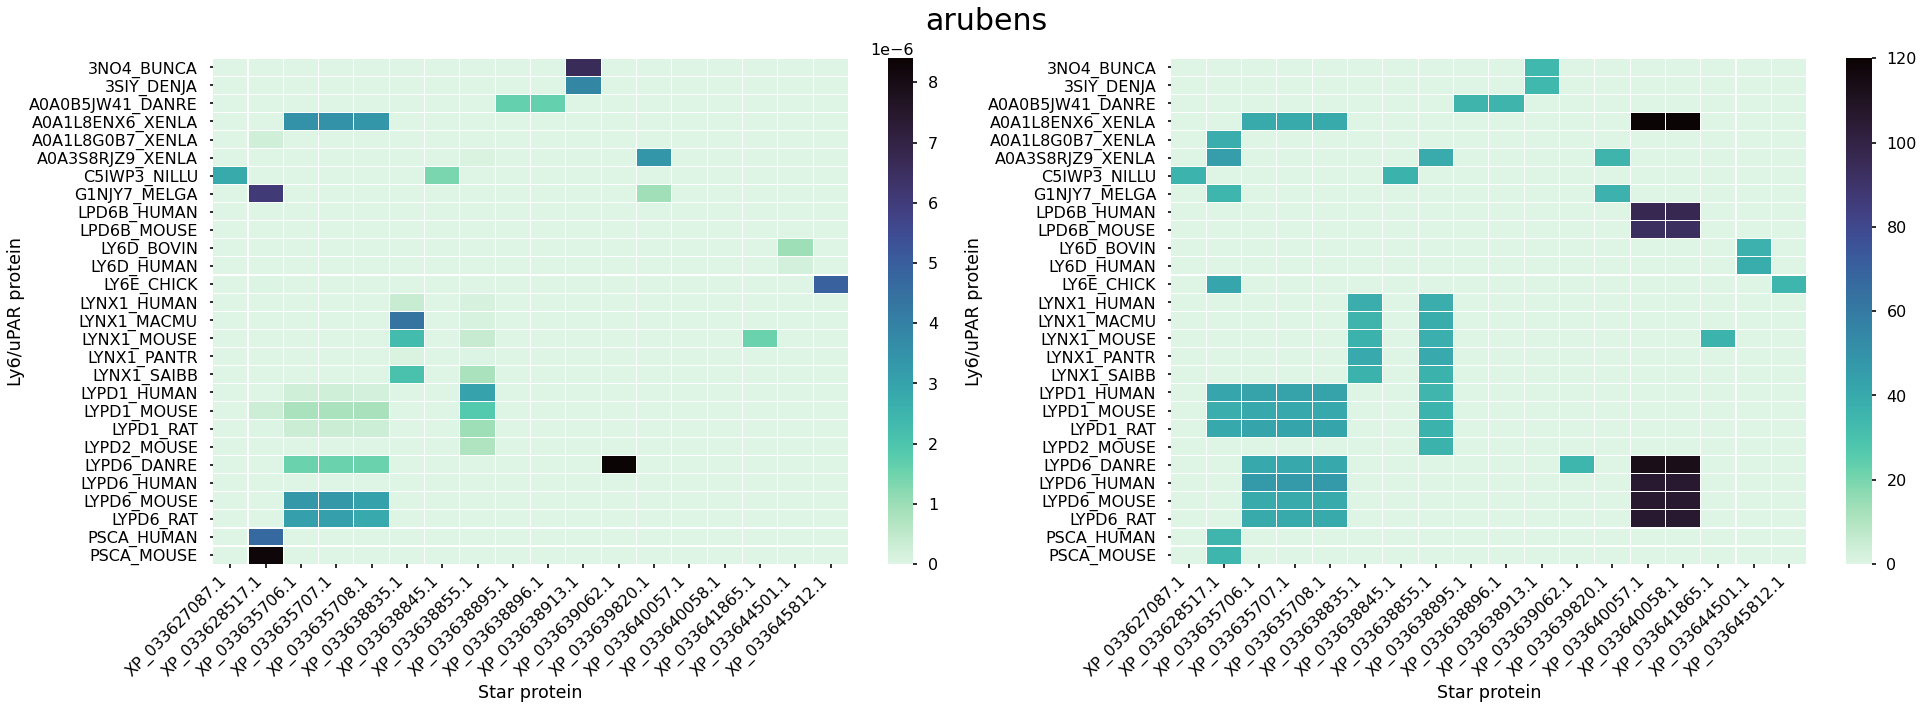

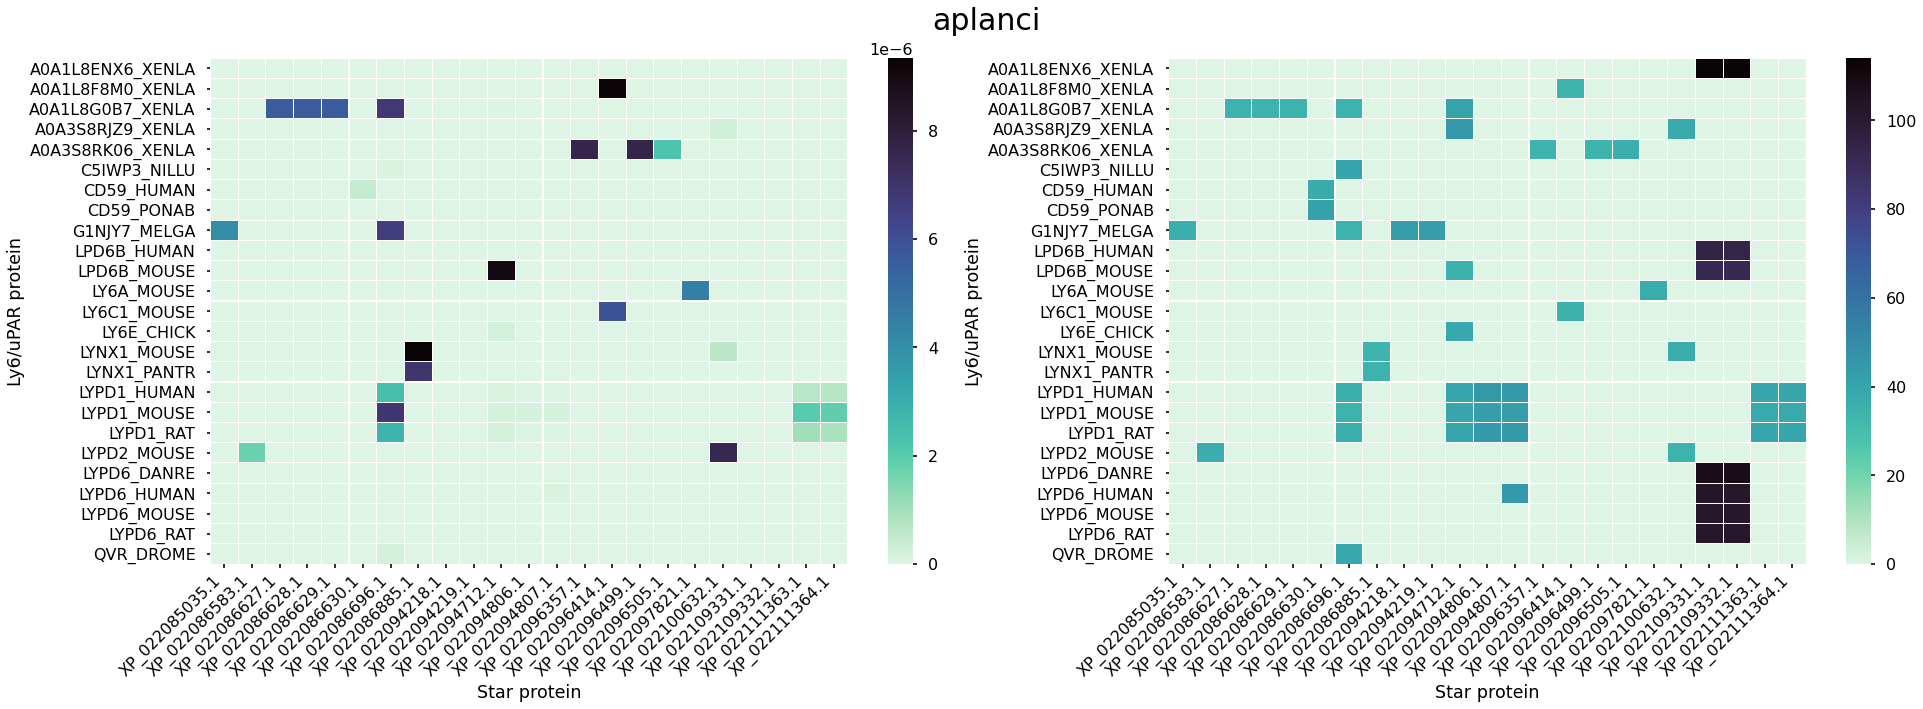

In [24]:
def print_heatmap(path):
    sp = 'Star protein'
    lp = 'Ly6/uPAR protein'
    ev = 'e-value'
    bs = 'bit score'
    df = pd.read_csv(path, sep='\t', header=None).rename(columns={
        0: sp,
        1: lp,
        10: ev,
        11: bs
    })
    kwargs = {'cmap': 'mako_r', 'linecolor': 'white', "linewidths": 0.1}
    fig, ax = plt.subplots(1, 2, figsize=(27.5, 10))
    sns.heatmap(data=df.pivot(index=lp, columns=sp, values=ev).fillna(0), ax=ax[0], **kwargs)
    sns.heatmap(data=df.pivot(index=lp, columns=sp, values=bs).fillna(0), ax=ax[1], **kwargs)
    for i in ax:
        i.set_xticklabels(i.get_xticklabels(), rotation = 45, ha="right", va='center_baseline')
    fig.suptitle(os.path.split(path)[-1].split('_')[0], fontsize=30)
    plt.tight_layout()
    plt.savefig(f"result/img/{path.split('/')[-1].rsplit('.', 1)[0]}.svg", facecolor='white', format='svg')
    plt.show()
print_heatmap('blast/arubens_blast_short.txt')
print_heatmap('blast/aplanci_blast_short.txt')

In [26]:
seq = "mkafyavlll avcvarasal kcytctdchl sgflaivens aecsvfqgsc rktvtggvvsrgcatgvece vtnllakcsk gaedncqicc dtdncngava akgsllglal alvtaafsryl".upper().replace(' ', '')
seq

'MKAFYAVLLLAVCVARASALKCYTCTDCHLSGFLAIVENSAECSVFQGSCRKTVTGGVVSRGCATGVECEVTNLLAKCSKGAEDNCQICCDTDNCNGAVAAKGSLLGLALALVTAAFSRYL'

In [28]:
len("LKCYTCTDCHLSGFLAIVENSAECSVFQGSCRKTVTGGVVSRGCATGVECEVTNLLAKCSKGAEDNCQICCDTDNCN")

77